In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import slippi
from slippi import Game
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss,accuracy_score
from sklearn.base import clone

from ipywidgets import interact

pd.set_option('display.max_columns', None)


import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from utils.data_utils import construct_df, ohe_chars_stage, characters, stages
from utils.modeling_utils import plot_log_loss, plot_multiple_log_loss, CV_model, plot_feature_importances,\
                            plot_win_probs, get_log_losses

import xgboost as xgb

In [59]:
all_games = pd.read_pickle('saved_data/final_processed_data.pkl')

In [60]:
all_games = all_games.groupby(['id']).first()

In [5]:
all_games

,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM,hit_diff,shield_diff,early_stock_diff,grab_diff,stock_diff_sc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Game_20060826T105525,DR_MARIO,CAPTAIN_FALCON,FOUNTAIN_OF_DREAMS,0,4.0,4.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Game_20060826T105844,DR_MARIO,CAPTAIN_FALCON,POKEMON_STADIUM,0,4.0,4.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Game_20060826T110230,DR_MARIO,CAPTAIN_FALCON,YOSHIS_STORY,0,4.0,4.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Game_20060826T110541,DR_MARIO,CAPTAIN_FALCON,DREAM_LAND_N64,0,4.0,4.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Game_20060826T110951,DR_MARIO,CAPTAIN_FALCON,BATTLEFIELD,0,4.0,4.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Game_20230505T093334,FOX,SHEIK,YOSHIS_STORY,0,4.0,4.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Game_20230505T094347,FOX,SHEI

In [6]:
all_games['stage'].value_counts()

BATTLEFIELD           4639
YOSHIS_STORY          3158
DREAM_LAND_N64        2809
FINAL_DESTINATION     2652
POKEMON_STADIUM       2458
FOUNTAIN_OF_DREAMS    2423
Name: stage, dtype: int64

In [68]:
def num_games_with_char(df, character):
    character = character.upper()
    char_in_game = np.array(df['p1_'+character].astype(int) | df['p2_'+character].astype(int))
    total = np.sum(char_in_game)
    #print(character + ': {:} appearances in {:} games'.format(total,len(df)))
    return total

def make_matchup_matrix(df, character_list):
    cl = (len(character_list))
    win_matrix = np.zeros((cl,cl))
    games_matrix = np.zeros((cl,cl))
          
    p1_list = df['p1_char']
    p2_list = df['p2_char']
    win_list = df['winner']
    
    for p1,p2,win in zip(p1_list,p2_list, win_list):
        p1_i = characters.index(p1)
        p2_i = characters.index(p2)
        win_matrix[p1_i,p2_i] += win
        win_matrix[p2_i,p1_i] += 1-win
        games_matrix[p1_i, p2_i] += 1
        games_matrix[p2_i, p1_i] += 1
    
    return win_matrix/games_matrix, win_matrix, games_matrix

def plot_matchup_heatmap(mat,character_list, num_chars, title=''):
    plt.figure(figsize = (15,14))
    fmt = '.2f' if mat.dtype == 'float64' else  'd'
    sns.heatmap(data=mat[:num_chars,:num_chars],
                annot=True, xticklabels = character_list[:num_chars],yticklabels = character_list[:num_chars],
                fmt=fmt, cmap = 'magma')
    plt.xlabel('Character 2')
    plt.ylabel('Character 1')
    plt.title(title)
    plt.show()
    

In [43]:
win_pct, wins, games = make_matchup_matrix(all_games, characters)


<ipython-input-42-3ef2506f21f2>:24: RuntimeWarning: invalid value encountered in true_divide
  return win_matrix/games_matrix, win_matrix, games_matrix


In [44]:
win_pct[0,2]

0.47430555555555554

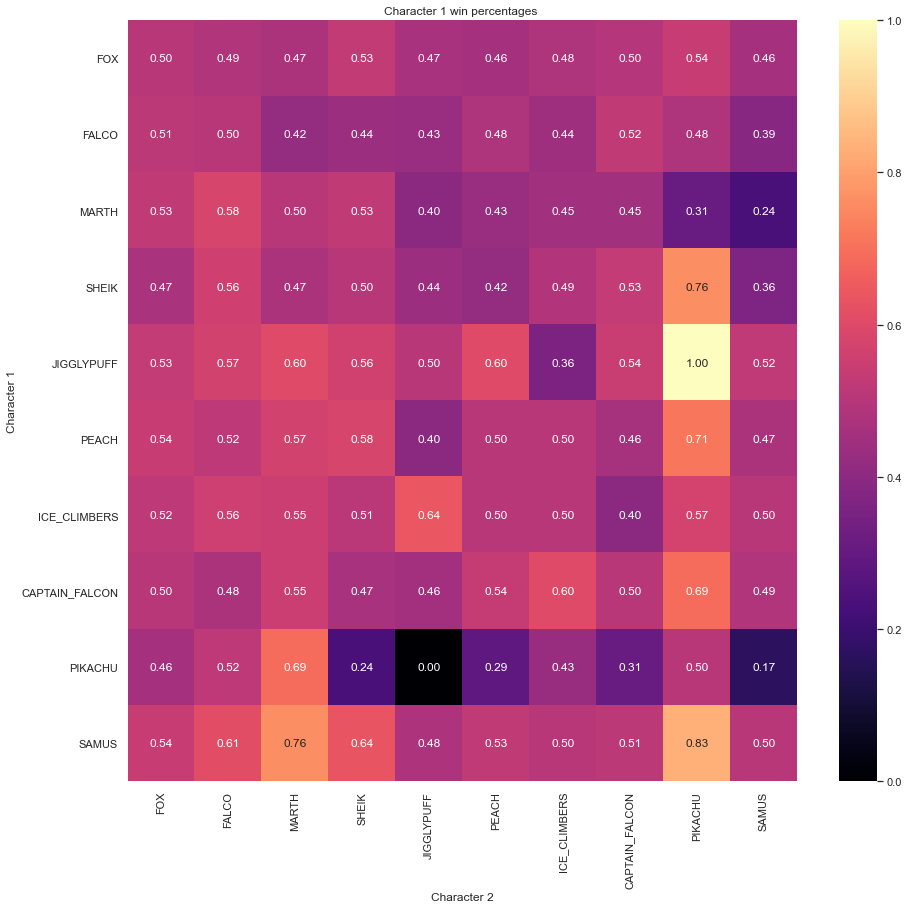

In [47]:
plot_matchup_heatmap(win_pct, characters, 10, title = 'Character 1 win percentages ')

In [69]:
num_games_with_char(all_games,'falco')

6673

In [71]:
all_games[(all_games['p1_char']=='JIGGLYPUFF') & (all_games['p2_char']=='PIKACHU')]

,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM,hit_diff,shield_diff,early_stock_diff,grab_diff,stock_diff_sc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Game_20190309T120059,JIGGLYPUFF,PIKACHU,BATTLEFIELD,0,4.0,4.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Game_20190309T120512,JIGGLYPUFF,PIKACHU,POKEMON_STADIUM,0,4.0,4.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [57]:
all_games = pd.read_pickle('saved_data/final_processed_data.pkl')
all_games_last = all_games.groupby(['id']).last()

In [61]:
all_games_last

,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM,hit_diff,shield_diff,early_stock_diff,grab_diff,stock_diff_sc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Game_20060826T105525,DR_MARIO,CAPTAIN_FALCON,FOUNTAIN_OF_DREAMS,10800,1.0,1.0,67.769997,85.699997,1,52.0,5.0,1.0,29.0,3.0,368.0,9.0,0.0,1287.0,58.0,10.0,0.0,34.0,1.0,204.0,7.0,0.0,2644.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-6.0,164.0,0.0,2.0,0.0
Game_20060826T105844,DR_MARIO,CAPTAIN_FALCON,POKEMON_STADIUM,12600,1.0,1.0,190.679993,32.360001,0,57.0,5.0,4.0,30.0,4.0,330.0,12.0,0.0,6080.0,57.0,5.0,0.0,31.0,3.0,113.0,6.0,0.0,2646.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,217.0,0.0,1.0,0.0
Game_20060826T110230,DR_MARIO,CAPTAIN_FALCON,YOSHIS_STORY,10500,1.0,1.0,77.830002,101.526245,1,52.0,7.0,3.0,23.0,7.0,308.0,4.0,0.0,1658.0,67.0,23.0,0.0,28.0,3.0,187.0,0.0,0.0,4205.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-15.0,121.0,0.0,4.0,0.0
Game_20060826T110541,DR_MARIO,CAPTAIN_FALCON,DREAM_LAND_N64,14100,1.0,1.0,111.459991,149.850006,1,59.0,9.0,3.0,31.0,1.0,387.0,8.0,0.0,2941.0,69.0,12.0,0.0,29.0,5.0,502.0,6.0,1.0,3937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-10.0,-115.0,-1.0,-4.0,0.0
Game_20060826T110951,DR_MARIO,CAPTAIN_FALCON,BATTLEFIELD,7800,1.0,1.0,76.250000,41.239998,0,35.0,2.0,2.0,18.0,2.0,228.0,3.0,1.0,2732.0,47.0,6.0,0.0,22.0,7.0,28.0,3.0,0.0,1597.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-12.0,200.0,1.0,-5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Game_20230505T093334,FOX,SHEIK,YOSHIS_STORY,11400,1.0,1.0,111.725113,0.000000,0,58.0,3.0,5.0,28.0,2.0,625.0,2.0,0.0,3115.0,52.0,17.0,6.0,12.0,4.0,549.0,8.0,0.0,628.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [62]:
win_stocks = all_games_last.apply(lambda x: x['p1_stocks'] if x['winner']==1 else x['p2_stocks'], axis =1)

In [64]:
win_stocks.mean()

2.0053475935828877

In [73]:
all_games['p1_char'].value_counts()

FOX               5143
FALCO             4151
MARTH             2382
CAPTAIN_FALCON    1452
SHEIK             1221
PEACH              881
JIGGLYPUFF         747
ICE_CLIMBERS       524
SAMUS              387
GANONDORF          186
DR_MARIO           181
LUIGI              164
PIKACHU            160
YOSHI              120
ZELDA               99
GAME_AND_WATCH      71
MARIO               61
LINK                58
DONKEY_KONG         40
NESS                26
PICHU               20
YOUNG_LINK          19
BOWSER              17
ROY                 16
MEWTWO              12
KIRBY                1
Name: p1_char, dtype: int64